In [1]:
import pytesseract as pt
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pdf2image import convert_from_path

In [2]:
def area(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (max(x)-min(x))*(max(y)-min(y))

def start_point(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (min(x),max(y))

def end_point(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (max(x),min(y))

def get_points(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (min(x),max(x),min(y),max(y))

def get_all_points(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            if (area(approx)>5000):
                coordinates.append(get_points(approx))
#                 print(area(approx))
#                 cv2.rectangle(image, start_point(approx),end_point(approx), (0, 255, 255), 5)
    return coordinates

def get_tables(image):
    coordinates = get_all_points(image)
    # print(len(coordinates))
    tables = []
    for coordinate in coordinates:
        tables.append(image[coordinate[2]:coordinate[3],coordinate[0]:coordinate[1]])
    return tables

def get_image_with_table(img):
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            if (area(approx)>5000):
                coordinates.append(get_points(approx))
#                 print(area(approx))
                cv2.rectangle(image, start_point(approx),end_point(approx), (0, 255, 255), 5)
    return image

In [72]:
# 15,15,40,40
def get_cells_coordinates(image,v_erode,v_dilate,h_erode,h_dilate):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

    vertical_lines = cv2.erode(img, vertical_kernel, iterations=v_erode)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=v_dilate)

    horizontal_lines = cv2.erode(img, hor_kernel, iterations=h_erode)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=h_dilate)

    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

    thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
    b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))
    
#     plt.imshow(vertical_horizontal_lines)
#     plt.show()

    contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    temp_bound_box = [cv2.boundingRect(c) for c in contours]
    (contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
    boundingBoxes=[]
    for box in temp_bound_box:
#         print(box)
        boundingBoxes.append(box)
    return vertical_horizontal_lines

def get_text_csv(bounding_boxes,image):
#     print(bounding_boxes)
    cols = len(np.unique(np.array(bounding_boxes)[:,0]))
    rows = len(np.unique(np.array(bounding_boxes)[:,1]))
    
    rows_start_points = sorted(np.unique(np.array(bounding_boxes)[:,1]))
    cols_start_points = sorted(np.unique(np.array(bounding_boxes)[:,0]))
    rows_end_points = sorted(np.unique(np.array(bounding_boxes)[:,1]+np.array(bounding_boxes)[:,3]))
    cols_end_points = sorted(np.unique(np.array(bounding_boxes)[:,0]+np.array(bounding_boxes)[:,2]))
    
    table = []
    for i in range(rows):
        table.append([])
        for j in range(cols):
            table[i].append(())

    
    for idx,box in enumerate(bounding_boxes):
        col_start, row_start, w, h = box
        row_end, col_end = row_start+h,col_start+w
        #     print(rows_start_points.index(row_start)-rows_end_points.index(row_end))
        for i in range(rows_start_points.index(row_start),rows_end_points.index(row_end)+1):
            for j in range(cols_start_points.index(col_start),cols_end_points.index(col_end)+1):
                table[i][j]=box
#                 print(i,j,idx)
#     display_cell(image,table[7][0])
    # text = []
    
    all_text = ''
    for idx,row in enumerate(table):
    #     text.append([])
        for cell in row:
#             print(cell)
            x, y, w, h = cell
            cell_image=image[y:y+h,x:x+w]
            kernel = np.ones((5,5),np.uint8)
            cell_image = cv2.erode(cell_image, kernel, iterations = 1)
            cell_image = cv2.resize(cell_image,(np.shape(cell_image)[1]//3,np.shape(cell_image)[0]//3),cv2.INTER_LINEAR)
            ocr_text = pt.image_to_string(cell_image,config='--psm 4',
                                          lang='pan').replace('\n','').replace('\x0c','').replace('_','')
            # print(ocr_text)
            all_text = all_text+ocr_text+','
        #         text[idx].append(ocr_text)
        all_text=all_text+'\n'
    return all_text

In [65]:
def get_cells_coordinates_include_verification(image,v_erode,v_dilate,h_erode,h_dilate):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

    vertical_lines = cv2.erode(img, vertical_kernel, iterations=v_erode)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=v_dilate)

    horizontal_lines = cv2.erode(img, hor_kernel, iterations=h_erode)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=h_dilate)

    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

    thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
    b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))

    contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    temp_bound_box = [cv2.boundingRect(c) for c in contours]
    (contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
    boundingBoxes=[]
    for box in temp_bound_box:
#         print(box)
        boundingBoxes.append(box)
    print(boundingBoxes[0][2:],(np.shape(image)[1],np.shape(image)[0]))
    if (boundingBoxes[0][2]==np.shape(image)[1] and np.shape(image)[0]==boundingBoxes[0][3]):
        print('same')
        return boundingBoxes[1:]
    if (np.shape(image)[1]-boundingBoxes[0][2]>200 or
              np.shape(image)[0]-boundingBoxes[0][3]>200):
        return boundingBoxes
    x = input()
    if (x=='n'):
        return boundingBoxes
    return boundingBoxes[1:]

In [66]:
book = 'data_books/punjabi/pp_kharif__pb_table.pdf'
images = convert_from_path(book,dpi=300)
tables = [get_tables(np.array(image)) for image in images]

In [67]:
# 21,40
error_pages=[58]

In [68]:
error_tables=[tables[i] for i in error_pages]

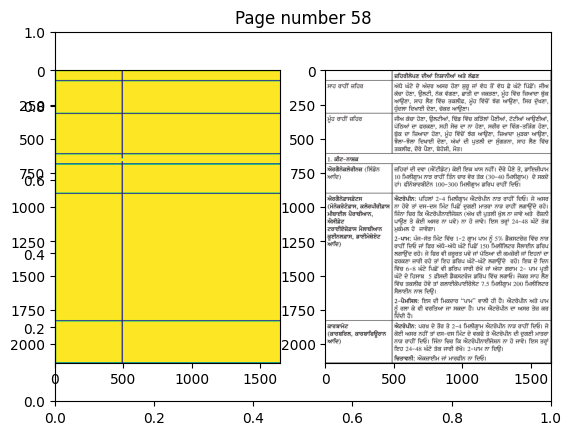

In [69]:
for idx,page in enumerate(error_tables):
    for table in page:
        plt.title(f'Page number {error_pages[idx]}')
        plt.subplot(121)
        plt.imshow(get_cells_coordinates(table,5,10,40,40))

        plt.subplot(122)
        plt.imshow(table)

        plt.show()

In [73]:
all_text = ''
for idx,table in enumerate(error_tables):
    all_text = all_text + f'page-{error_pages[idx]}\n'
#     print(len(table))
    if (len(table)>3):
        print(error_page[idx],len(table))
    else:
        for curr in table:
            try:
                bounding_boxes = get_cells_coordinates_include_verification(curr,5,10,40,40)
                ocr = get_text_csv(bounding_boxes,curr)
                all_text = all_text + ocr + '\n'
                print(ocr)
            except:
                continue
    all_text = all_text + '\n\n\n\n'

(1151, 67) (1649, 2137)
,ਜ਼ਹਿਰੀਲੇਪਣ ਦੀਆਂ ਨਿਸ਼ਾਨੀਆਂ ਅਤੇ ਲੱਛਣ,
ਸਾਹ ਰਾਹੀਂ ਜ਼ਹਿਰ,ਐਧੇ ਘੰਟੇ ਦੇ ਅੰਦਰ ਅਸਰ ਹੋਣਾ ਸ਼ੁਰੂ ਜਾਂ ਵੱਧ ਤੋਂ ਵੇਂਧ ਛੇ ਘੰਟੇ ਪਿੱਛੋਂ। ਜੀਅਕੱਚਾ ਹੋਣਾ, ਉਲਟੀ, ਨੱਕ ਵੇਗਣਾ, ਛਾਤੀ ਦਾ ਜਕੜਣਾ, ਮੂੰਹ ਵਿੱਚ ਜ਼ਿਆਦਾ ਸ਼ੁੱਕਆਉਣਾ, ਸਾਹ ਲੈਣ ਵਿੱਚ ਤਕਲੀਫ਼, ਮੂੰਹ ਵਿੱਚੋਂ ਝੱਗ ਆਉਣਾ, ਸਿਰ ਜੁੱਖਣਾ,ਗੁੰਦਲਾ ਦਿਖਾਈ ਦੇਣਾ, ਚੱਕਰ ਆਉਣਾ।,
ਮੂੰਹ ਰਾਹੀਂ ਜ਼ਹਿਰ,ਜੀਅ ਕੱਚਾ ਹੋਣਾ, ਉਲਟੀਆਂ, ਢਿੱਡ ਵਿੱਚ ਕੜਿੱਲਾਂ ਪੈਣੀਆਂ, ਟੱਟੀਆਂ ਆਉਣੀਆਂ,ਪੱਠਿਆਂ ਦਾ ਫਰਕਣਾ, ਸਹੀ ਸੋਚ ਦਾ ਨਾ ਹੋਣਾ, ਸਰੀਰ ਦਾ ਵਿੰਗ-ਤੜਿੰਗ ਹੋਣਾ,ਛੱਕ ਦਾ ਜ਼ਿਆਦਾ ਹੋਣਾ, ਹੂੰਹ ਵਿੱਚੋਂ ਝੱਂਗ ਆਉਣਾ, ਜ਼ਿਆਦਾ ਮੁੜਕਾ ਆਉਣਾ,ਝੋਲਾ-ਝੋਲਾ ਦਿਖਾਈ ਦੇਣਾ, ਅੱਖਾਂ ਦੀ ਪੁਤਲੀ ਦਾ ਸੁੰਗੜਨਾ, ਸਾਹ ਲੈਣ ਵਿੱਚਤਕਲੀਫ, ਦੋਵੇ ਪੈਣਾ, ਬੇਹੋਸ਼ੀ, ਮੋਤ।,
1. ਕੀਟ-ਨਾਸ਼ਕ,1. ਕੀਟ-ਨਾਸ਼ਕ,
,ਜ਼ਹਿਰਾਂ ਦੀ ਦਵਾ (ਐੱਟੀਡੋਟ) ਕੋਈ ਇਕ ਖਾਸ ਨਹੀਂ। ਦੋਰੇ ਪੈਣੇ ਤੇ, ਸਾਜੀਪਾਮ2 ਅਕਿ ਲਗ ਰਾਹੀ ਤਿੰਨ ਚਰ ਵੇਰ ਤੱਕ (੩040ਹਾਂ ਭੀਨੋਬਾਰਬੀਟੌਨ 100-300 ਮਿਲੀੜ੍ਰਾਮ ਡਚਿਪ ਰਾਹੀਂ ,
,ਐਟਰੋਪੀਨ: ਪਹਿਲਾਂ 2-4 ਮਿਲੀਗ੍ਰਾਮ ਐਟਰੋਪੀਨ ਨਾੜ ਰਾਹੀਂ ਦਿਓ। ਜੇ ਅਸਰਨਾ ਹੋਵੇ ਤਾਂ ਦਸ-ਦਸ ਮਿੰਟ ਪਿਛੋਂ ਦੁਗਣੀ ਮਾਤਰਾ ਨਾੜ ਰਾਹੀਂ ਲਗਾਊਂਦੇ ਰਹੋ।ਜਿੰਨਾ ਚਿਰ ਕਿ ਐਟਰੋਪੀਨਾਈਜੇਸ਼ਨ (ਐੱਖ ਦੀ ਪੁਤਲੀ ਖੁੱਲ ਨਾ ਜਾਵੇ ਅਤੇ ਰੌਸ਼ਨੀਪਾਉਣ ਤੇ ਕੋਈ ਅਸਰ ਨਾਂ ਪਵੇ) ਨਾ ਹੋ ਜਾਵੇ। ਇਸ ਤ

In [74]:
print(all_text)

page-58
,ਜ਼ਹਿਰੀਲੇਪਣ ਦੀਆਂ ਨਿਸ਼ਾਨੀਆਂ ਅਤੇ ਲੱਛਣ,
ਸਾਹ ਰਾਹੀਂ ਜ਼ਹਿਰ,ਐਧੇ ਘੰਟੇ ਦੇ ਅੰਦਰ ਅਸਰ ਹੋਣਾ ਸ਼ੁਰੂ ਜਾਂ ਵੱਧ ਤੋਂ ਵੇਂਧ ਛੇ ਘੰਟੇ ਪਿੱਛੋਂ। ਜੀਅਕੱਚਾ ਹੋਣਾ, ਉਲਟੀ, ਨੱਕ ਵੇਗਣਾ, ਛਾਤੀ ਦਾ ਜਕੜਣਾ, ਮੂੰਹ ਵਿੱਚ ਜ਼ਿਆਦਾ ਸ਼ੁੱਕਆਉਣਾ, ਸਾਹ ਲੈਣ ਵਿੱਚ ਤਕਲੀਫ਼, ਮੂੰਹ ਵਿੱਚੋਂ ਝੱਗ ਆਉਣਾ, ਸਿਰ ਜੁੱਖਣਾ,ਗੁੰਦਲਾ ਦਿਖਾਈ ਦੇਣਾ, ਚੱਕਰ ਆਉਣਾ।,
ਮੂੰਹ ਰਾਹੀਂ ਜ਼ਹਿਰ,ਜੀਅ ਕੱਚਾ ਹੋਣਾ, ਉਲਟੀਆਂ, ਢਿੱਡ ਵਿੱਚ ਕੜਿੱਲਾਂ ਪੈਣੀਆਂ, ਟੱਟੀਆਂ ਆਉਣੀਆਂ,ਪੱਠਿਆਂ ਦਾ ਫਰਕਣਾ, ਸਹੀ ਸੋਚ ਦਾ ਨਾ ਹੋਣਾ, ਸਰੀਰ ਦਾ ਵਿੰਗ-ਤੜਿੰਗ ਹੋਣਾ,ਛੱਕ ਦਾ ਜ਼ਿਆਦਾ ਹੋਣਾ, ਹੂੰਹ ਵਿੱਚੋਂ ਝੱਂਗ ਆਉਣਾ, ਜ਼ਿਆਦਾ ਮੁੜਕਾ ਆਉਣਾ,ਝੋਲਾ-ਝੋਲਾ ਦਿਖਾਈ ਦੇਣਾ, ਅੱਖਾਂ ਦੀ ਪੁਤਲੀ ਦਾ ਸੁੰਗੜਨਾ, ਸਾਹ ਲੈਣ ਵਿੱਚਤਕਲੀਫ, ਦੋਵੇ ਪੈਣਾ, ਬੇਹੋਸ਼ੀ, ਮੋਤ।,
1. ਕੀਟ-ਨਾਸ਼ਕ,1. ਕੀਟ-ਨਾਸ਼ਕ,
,ਜ਼ਹਿਰਾਂ ਦੀ ਦਵਾ (ਐੱਟੀਡੋਟ) ਕੋਈ ਇਕ ਖਾਸ ਨਹੀਂ। ਦੋਰੇ ਪੈਣੇ ਤੇ, ਸਾਜੀਪਾਮ2 ਅਕਿ ਲਗ ਰਾਹੀ ਤਿੰਨ ਚਰ ਵੇਰ ਤੱਕ (੩040ਹਾਂ ਭੀਨੋਬਾਰਬੀਟੌਨ 100-300 ਮਿਲੀੜ੍ਰਾਮ ਡਚਿਪ ਰਾਹੀਂ ,
,ਐਟਰੋਪੀਨ: ਪਹਿਲਾਂ 2-4 ਮਿਲੀਗ੍ਰਾਮ ਐਟਰੋਪੀਨ ਨਾੜ ਰਾਹੀਂ ਦਿਓ। ਜੇ ਅਸਰਨਾ ਹੋਵੇ ਤਾਂ ਦਸ-ਦਸ ਮਿੰਟ ਪਿਛੋਂ ਦੁਗਣੀ ਮਾਤਰਾ ਨਾੜ ਰਾਹੀਂ ਲਗਾਊਂਦੇ ਰਹੋ।ਜਿੰਨਾ ਚਿਰ ਕਿ ਐਟਰੋਪੀਨਾਈਜੇਸ਼ਨ (ਐੱਖ ਦੀ ਪੁਤਲੀ ਖੁੱਲ ਨਾ ਜਾਵੇ ਅਤੇ ਰੌਸ਼ਨੀਪਾਉਣ ਤੇ ਕੋਈ ਅਸਰ ਨਾਂ ਪਵੇ) ਨਾ ਹੋ ਜਾਵੇ। ਇਸ ਤਰ੍ਹਾਂ 24-48 ਬੰਟੇ